In [7]:
from network import Network
from utils import unzip
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [8]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def render(ims):

    fig = plt.figure()
    frames = [[plt.imshow(im, animated=True)] for im in ims]
    plt.close()
    
    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)

    return ani

In [101]:
comm_side = 3
comms_per_side = 3
threshold = int((comm_side * comm_side - 1) / 2)
wires = comm_side * comm_side - 1
net = Network(
    comm_side=comm_side,
    comms_per_side=comms_per_side,
    locality=0.1,
    threshold=threshold,
)
print(f"wires {wires}, threshold {threshold}")
C = comm_side * comm_side

assert C*(C-1) - threshold*C >= threshold*(threshold+1)
print(f"Spare capacity: {(C*(C-1) - threshold*C)/(threshold*(threshold+1))}")

wires 8, threshold 4
Spare capacity: 1.8


In [102]:
#net.initialize(wires)
net.cheat()

In [84]:
results = [net.episode() for t in trange(10)]
results

100%|██████████| 10/10 [00:00<00:00, 14.77it/s]


[Results(steps=81, avg_spikes=0.10989178478890413, mu=0.17665615141955837, communities_activated=64),
 Results(steps=69, avg_spikes=0.09804974056181785, mu=0.31932773109243695, communities_activated=40),
 Results(steps=51, avg_spikes=0.08569353667392883, mu=0.4306306306306306, communities_activated=16),
 Results(steps=30, avg_spikes=0.05720164609053498, mu=0.4843137254901961, communities_activated=0),
 Results(steps=28, avg_spikes=0.04982363315696649, mu=0.5645833333333333, communities_activated=0),
 Results(steps=24, avg_spikes=0.05298353909465021, mu=0.6116071428571429, communities_activated=0),
 Results(steps=24, avg_spikes=0.05298353909465021, mu=0.6053268765133172, communities_activated=0),
 Results(steps=24, avg_spikes=0.048868312757201646, mu=0.6330749354005168, communities_activated=0),
 Results(steps=22, avg_spikes=0.04826038159371493, mu=0.643646408839779, communities_activated=0),
 Results(steps=22, avg_spikes=0.04938271604938271, mu=0.6724137931034483, communities_activated

In [85]:
steps, avg_spikes, mus, communities_activated = unzip(results)

In [86]:
# metrics = []
# t = trange(10)
# spikes = []
# for it in t:
#     net.spark()
#     t.set_description(f"ITERATION {it}")
#     for ep in range(10):
#         net.check()
#         net.gossip()
#         net.update()
#         # net.inspect()
#         net.optimize()
#         if net.dead():
#             break
#     episode = np.array(net.spiking_history[-ep:])
#     avg_spikes = episode.sum() / episode.size
#     metrics.append((ep, avg_spikes, net.mu()))

In [87]:
# eps, avg_spikes, mus = unzip(metrics)

# spikes = [state.sum()/state.size for state in net.spiking_history]

# def ep_range(eps):
#     # add one to make the episodes not overlap
#     eps_ends = (np.array(eps)+1).cumsum()
#     # make time chinks
#     time = [list(range(start,stop)) for start, stop in zip(eps_ends, eps_ends[1:])]
#     # yield triplets
#     for ((start, stop),t) in zip(zip(eps_ends, eps_ends[1:]),time):
#         yield (t, start, stop)

# for t,start,stop in ep_range(eps):
#     plt.plot(t, spikes[start:stop])

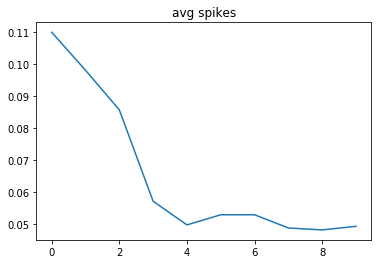

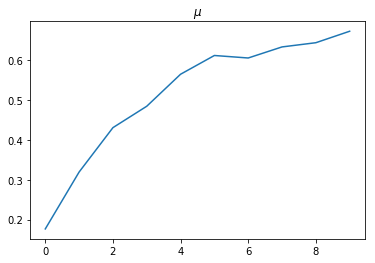

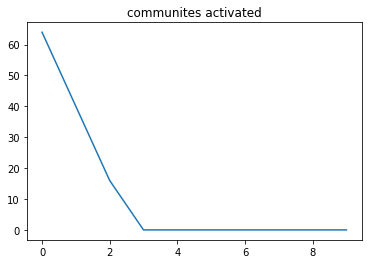

In [91]:
plt.title("avg spikes")
plt.plot(avg_spikes)
plt.show()
plt.title("$\mu$")
plt.plot(mus)
plt.show()
plt.title("communites activated")
plt.plot(communities_activated)
plt.show()

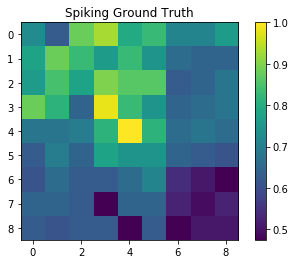

In [79]:
# To check how well gossipping is doing I'll compute the activity ground-truth
gt = np.array(net.spiking_history).sum(axis=0)
gt /= gt.max() # we are interested in proportions of activity, not actual value
plt.imshow(gt)
plt.title("Spiking Ground Truth")
plt.colorbar()

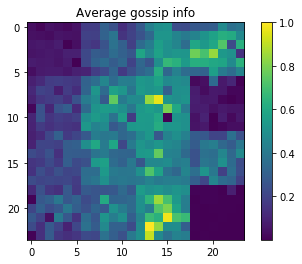

In [14]:
# gather the info shared by all agents by gossiping
collective_info = np.array([node.info for node in net.nodes])
collective_info = collective_info.sum(axis=0)
        
collective_info /= collective_info.max()
plt.imshow(collective_info)
plt.title("Average gossip info")
plt.colorbar()

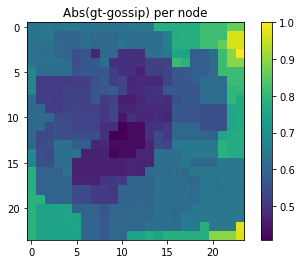

In [15]:
# compare the two by the abs diff of each node against the gt
# gossip status -> (gt-gossip)
gossip = np.zeros((net.N,net.N))
for node in net.nodes:
    gossip_matrix = np.copy(node.info)
    # normalize gossip matrix if there is any gossip
    gossip_level = node.info.max()
    if(gossip_level > 0):
        gossip_matrix /= gossip_level
    perf = np.abs(gt-gossip_matrix).sum()
    gossip[node.coords] = perf

gossip /= gossip.max()

plt.imshow(gossip)
plt.colorbar()
plt.title("Abs(gt-gossip) per node")
plt.show()

In [17]:
def render_diffusion():
    comm_side = 6
    comms_per_side = 4
    threshold = int((comm_side * comm_side - 1) / 2)
    wires = comm_side * comm_side - 1
    net = Network(
        comm_side=comm_side,
        comms_per_side=comms_per_side,
        locality=0.1,
        threshold=threshold,
    )
    print(f"wires {wires}, threshold {threshold}")
    net.initialize(wires)
    frames = []
    t = trange(50)
    for it in t:
        net.spark()
        t.set_description(f"ITERATION {it}")
        for ep in range(15):
            net.check()
            net.gossip()
            net.update()
            # net.inspect()
            net.optimize()
            
            # compare the two by the abs diff of each node against the gt
            # gossip status -> (gt-gossip)
            gossip = np.zeros((net.N,net.N))
            # To check how well gossipping is doing I'll compute the activity ground-truth
            gt = np.array(net.spiking_history).sum(axis=0)
            gt /= gt.max() # we are interested in proportions of activity, not actual value
            for node in net.nodes:
                gossip_matrix = np.copy(node.info)
                # normalize gossip matrix if there is any gossip
                gossip_level = node.info.max()
                if(gossip_level > 0):
                    gossip_matrix /= gossip_level
                perf = np.abs(gt-gossip_matrix).sum()
                gossip[node.coords] = perf

            gossip /= gossip.max()

            
            frames.append(gossip)
            
            if net.dead():
                break
    frames = np.array(frames)
    frames /= frames.max()
    return render(frames)

diff_render = render_diffusion()



  0%|          | 0/50 [00:00<?, ?it/s]

ITERATION 0:   0%|          | 0/50 [00:00<?, ?it/s]

wires 35, threshold 17




ITERATION 0:   2%|▏         | 1/50 [00:00<00:10,  4.80it/s]

ITERATION 1:   2%|▏         | 1/50 [00:00<00:10,  4.80it/s]

ITERATION 1:   4%|▍         | 2/50 [00:00<00:10,  4.68it/s]

ITERATION 2:   4%|▍         | 2/50 [00:00<00:10,  4.68it/s]

ITERATION 2:   6%|▌         | 3/50 [00:00<00:10,  4.37it/s]

ITERATION 3:   6%|▌         | 3/50 [00:00<00:10,  4.37it/s]

ITERATION 3:   8%|▊         | 4/50 [00:00<00:10,  4.55it/s]

ITERATION 4:   8%|▊         | 4/50 [00:00<00:10,  4.55it/s]

ITERATION 4:  10%|█         | 5/50 [00:01<00:10,  4.21it/s]

ITERATION 5:  10%|█         | 5/50 [00:01<00:10,  4.21it/s]

ITERATION 5:  12%|█▏        | 6/50 [00:01<00:10,  4.04it/s]

ITERATION 6:  12%|█▏        | 6/50 [00:01<00:10,  4.04it/s]

ITERATION 6:  14%|█▍        | 7/50 [00:01<00:10,  4.17it/s]

ITERATION 7:  14%|█▍        | 7/50 [00:01<00:10,  4.17it/s]

ITERATION 7:  16%|█▌        | 8/50 [00:01<00:10,  3.89it/s]

ITERATION 8:  16%|█▌        | 8/50 [00:01<00:10,  3.89it/s]

ITERATION 8:  18%|█▊  

In [18]:
diff_render

In [19]:
diff_render.save("gossip_diffusion.mp4")

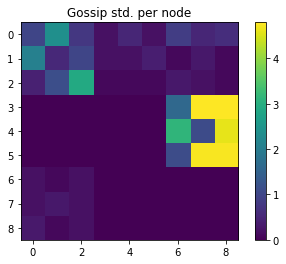

In [16]:
# check agents agreement using the std of their gossip "matrices"
# compare the previous gt with the info shared by all agents by gossiping
collective_info = np.array([node.info for node in net.nodes])
        
plt.imshow(collective_info.std(axis=0))
plt.title("Gossip std. per node")
plt.colorbar()

Text(0.5, 1.0, 'Communities')

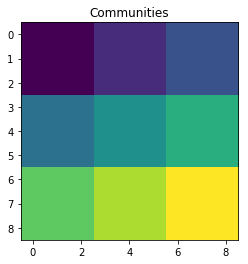

In [17]:
comms = np.zeros((net.N,net.N))
for node in net.nodes:
    comms[node.coords] = node.community
plt.imshow(comms)
plt.title("Communities")

In [93]:
spike_ani = render(net.spiking_history)

In [94]:
spike_ani

In [98]:
spike_ani.save("failed_spikes.mp4")

In [95]:
activ_ani = render(net.activity_history)

In [96]:
activ_ani

In [99]:
activ_ani.save("failed_activity.mp4")

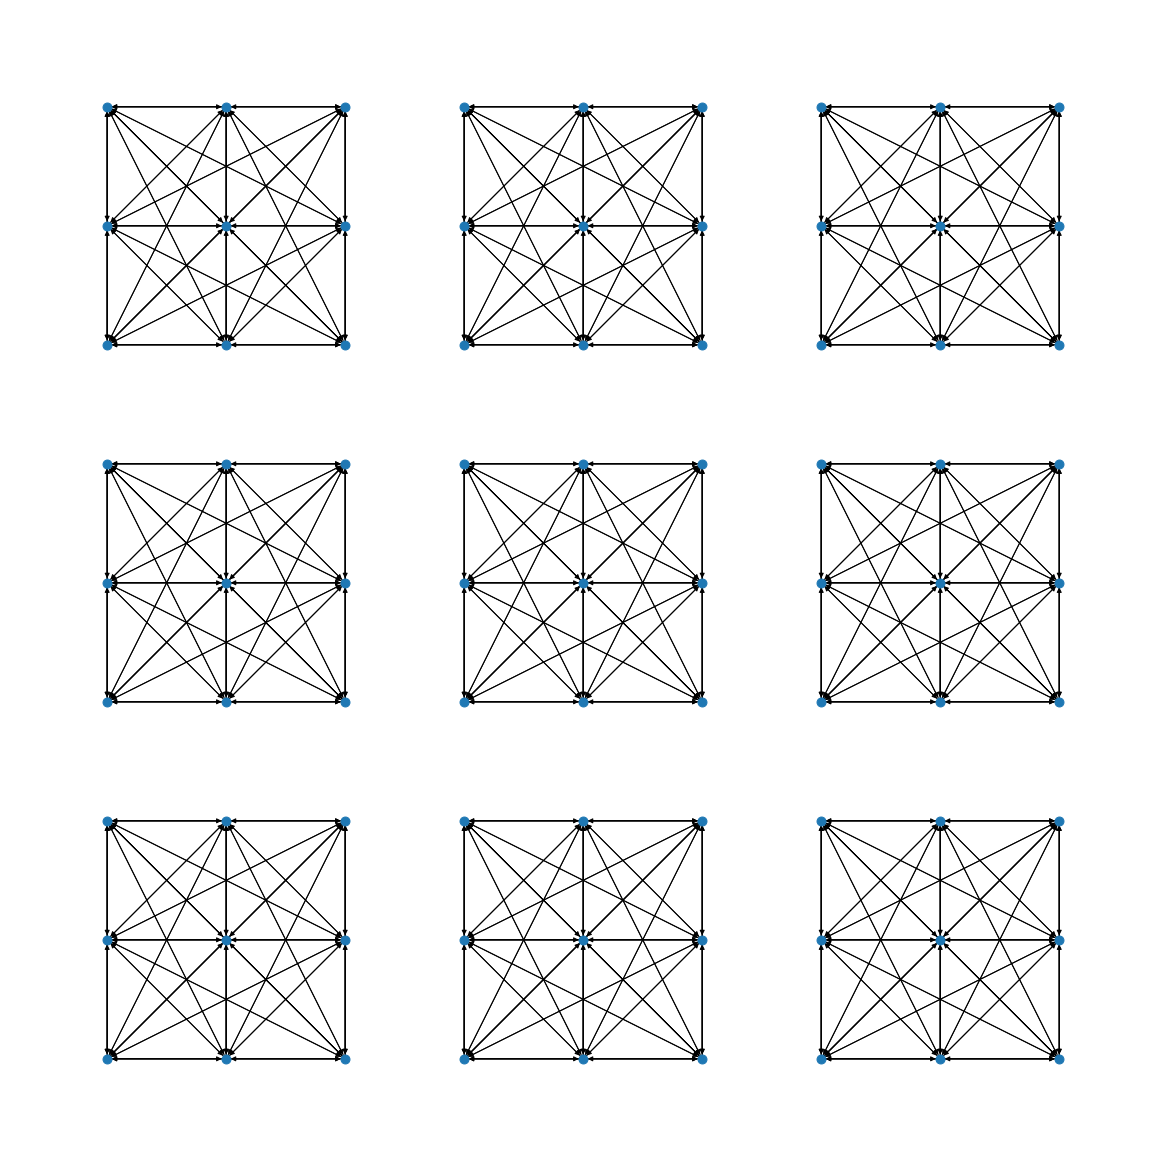

In [103]:
net.show()
plt.savefig('total_modularity.png')

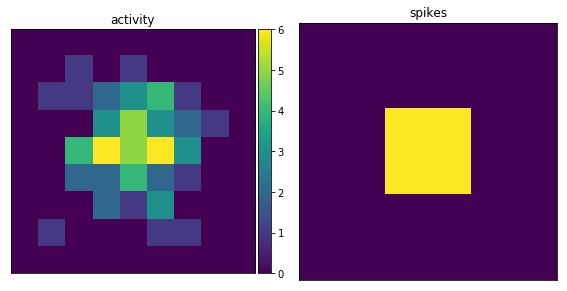

In [6]:
net.spark()
net.check()
net.gossip(sample=False)
net.update()
net.inspect()

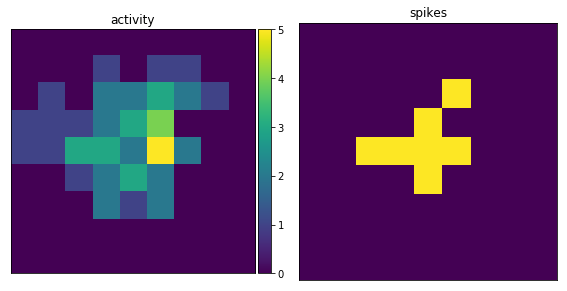

In [7]:
net.check()
net.gossip(sample=False)
net.update()
net.inspect()

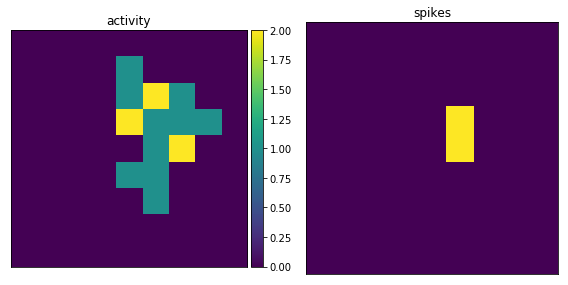

In [8]:
net.check()
net.gossip(sample=False)
net.update()
net.inspect()

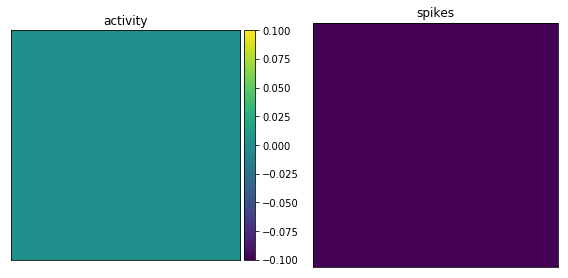

In [9]:
net.check()
net.gossip(sample=False)
net.update()
net.inspect()

In [49]:
from utils import make_communities, id_to_coords, unzip
N = 6
C = 3*3
board = np.zeros((6,6))

In [50]:
comm_coords = [[id_to_coords(node, N) for node in community] for community in make_communities(3,2)]
comm_coords

[[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)],
 [(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5)],
 [(3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2)],
 [(3, 3), (3, 4), (3, 5), (4, 3), (4, 4), (4, 5), (5, 3), (5, 4), (5, 5)]]

In [51]:
comm_masks = [tuple(unzip(coords)) for coords in comm_coords]
comm_masks

[((0, 0, 0, 1, 1, 1, 2, 2, 2), (0, 1, 2, 0, 1, 2, 0, 1, 2)),
 ((0, 0, 0, 1, 1, 1, 2, 2, 2), (3, 4, 5, 3, 4, 5, 3, 4, 5)),
 ((3, 3, 3, 4, 4, 4, 5, 5, 5), (0, 1, 2, 0, 1, 2, 0, 1, 2)),
 ((3, 3, 3, 4, 4, 4, 5, 5, 5), (3, 4, 5, 3, 4, 5, 3, 4, 5))]

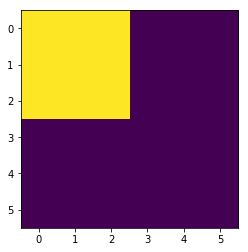

In [52]:
for i,j in comm_coords[0]:
    board[i][j] = 1
    
plt.imshow(board)

In [60]:
sum(board[mask].sum() == C for mask in comm_masks)

1

In [9]:
for i in range(4):
    for j in range(3):
        print(i,j)
        if j > 0:
            break

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
